<a href="https://www.kaggle.com/code/javihm77/catboost-baseline-chapu-optuna?scriptVersionId=132533635" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Catboost Baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import polars as pl
import gc
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
from time import sleep
import pickle
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Files

In [3]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ) ,
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]

In [5]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [6]:
pl.toggle_string_cache(True)

In [7]:
%%time

train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
        )

CPU times: user 49.8 s, sys: 21.1 s, total: 1min 10s
Wall time: 1min 7s


# Reducing training file

In [8]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [9]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3264.77 MB
Memory usage of dataframe train_subset became 1802.58 MB


In [10]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 18), (8844238, 18), (13471703, 18))

In [11]:
df3.head(8)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32
20090312431273200,512,836732,"""navigate_click…","""undefined""",13,null,290.153564,-204.499359,null,null,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",0
20090312431273200,513,837245,"""navigate_click…","""undefined""",13,null,353.805603,-210.332062,21.0,0.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",513
20090312431273200,514,837779,"""navigate_click…","""undefined""",13,null,587.680054,-280.706238,108.0,44.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",534
20090312431273200,515,838446,"""navigate_click…","""undefined""",13,null,751.496887,-102.15329,43.0,124.0,null,null,"""toentry""","""tunic.capitol_…","""text_fqid_None…","""13-22""",667
20090312431273200,516,839629,"""map_hover""","""basic""",13,null,null,null,null,null,67.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1183
20090312431273200,517,840662,"""map_hover""","""basic""",13,null,null,null,null,null,983.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1033
20090312431273200,518,840780,"""map_hover""","""basic""",13,null,null,null,null,null,100.0,null,"""tunic.historic…","""tunic.capitol_…","""text_fqid_None…","""13-22""",118
20090312431273200,519,840830,"""map_hover""","""basic""",13,null,null,null,null,null,35.0,null,"""tunic.capitol_…","""tunic.capitol_…","""text_fqid_None…","""13-22""",50


In [12]:
#Delete train to liberate memory
del train
gc.collect()

30

# Feature Engineering

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
                                              |(pl.col("fqid")=='logbook.page.bingo'))
                    .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                                pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                                pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')

CPU times: user 11.6 s, sys: 926 ms, total: 12.5 s
Wall time: 6.61 s


In [16]:
%%time
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')

CPU times: user 30.9 s, sys: 1.16 s, total: 32 s
Wall time: 17.1 s


In [17]:
%%time
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

CPU times: user 49.5 s, sys: 1.27 s, total: 50.8 s
Wall time: 26.5 s


In [18]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [19]:
df1.shape

(23562, 2344)

In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [22]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [23]:
df1.shape

(23562, 2350)

In [24]:
null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.7].index)
drop2 = list(null2[null2 > 0.7].index)
drop3 = list(null3[null3 > 0.7].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        #print(col)
        drop1.append(col)
        #sleep(0.1)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        #print(col)
        drop2.append(col)
        #sleep(0.1)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        #print(col)
        drop3.append(col)
        #sleep(0.1)

1225 1040 890


  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 487 787 1042 features
We will train with 23562 users info


# Optuna Parameters optimization

In [27]:
def objective(trial,X,y):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    
    cat_params = {
        "depth": trial.suggest_int("depth", 1, 9),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'n_estimators': trial.suggest_int('n_estimators', 150, 750),
        #'iterations': trial.suggest_int('iterations', 1, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'random_seed': 42,
        'verbose': False,
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 1),
        #"subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "used_ram_limit": "6gb",
        'eval_metric': 'AUC'
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    gbm = CatBoostClassifier(**cat_params)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=7)

    preds = gbm.predict(valid_x)
    #pred_labels = np.rint(preds)
    pred_labels = (preds > 0.63).astype('int')

    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy

In [28]:
# %%time

rf_best_params = []
studies = []

# ITERATE THRU QUESTIONS 1 THRU 18
for t in tqdm(range(1,19)): #1-19
        
    if t <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("")    
    print("#"*25)
    print(f'question{t}, with{len(FEATURES)}features')
    print('#'*25)
            
    # TRAIN DATA
    train_x = df[FEATURES]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
    
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_x, train_y['correct'])
    
    #Optuna 
    study = optuna.create_study(study_name=f"catboost_{t}",direction="maximize")
    study.optimize(func, n_trials=10, timeout=500)
    
    print(f'*** Model: {grp}_{t}')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print('Best value:', study.best_value)
    
    rf_best_params.append(study.best_trial.params)
    studies.append(study)
        
print("-"*80)


  0%|          | 0/18 [00:00<?, ?it/s]


#########################
question1, with487features
#########################


[I 2023-06-06 15:24:26,698] A new study created in memory with name: catboost_1
[I 2023-06-06 15:25:09,342] Trial 0 finished with value: 0.7528646201725845 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 596, 'learning_rate': 0.06455443044837268, 'objective': 'Logloss', 'l2_leaf_reg': 0.092265855766729, 'colsample_bylevel': 0.3579004969878538, 'min_data_in_leaf': 41, 'subsample': 0.6663841718712422}. Best is trial 0 with value: 0.7528646201725845.
[I 2023-06-06 15:25:35,806] Trial 1 finished with value: 0.7578158155326071 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 731, 'learning_rate': 0.0880395995381277, 'objective': 'Logloss', 'l2_leaf_reg': 0.37935973725805827, 'colsample_bylevel': 0.7091274156358276, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.7578158155326071.
[I 2023-06-06 15:25:43,658] Trial 2 finished with value: 0.7271184043004668 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 341, 'l

*** Model: 0-4_1
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 731, 'learning_rate': 0.0880395995381277, 'objective': 'Logloss', 'l2_leaf_reg': 0.37935973725805827, 'colsample_bylevel': 0.7091274156358276, 'min_data_in_leaf': 17}
Best value: 0.7578158155326071

#########################
question2, with487features
#########################


[I 2023-06-06 15:26:21,071] Trial 0 finished with value: 0.9783562031404724 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 621, 'learning_rate': 0.024788318986894847, 'objective': 'Logloss', 'l2_leaf_reg': 0.45104253488077983, 'colsample_bylevel': 0.6595312632500527, 'min_data_in_leaf': 73, 'bagging_temperature': 7.266051866174376}. Best is trial 0 with value: 0.9783562031404724.
[I 2023-06-06 15:26:24,123] Trial 1 finished with value: 0.9780732776913283 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 262, 'learning_rate': 0.0034670960919295913, 'objective': 'Logloss', 'l2_leaf_reg': 0.1271831211029182, 'colsample_bylevel': 0.5308378073139333, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9783562031404724.
[I 2023-06-06 15:26:32,439] Trial 2 finished with value: 0.9797708303861933 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 226, 'learning_rate': 0.0002352756399859273, 'objective': 'Logloss', 'l2_l

*** Model: 0-4_2
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 391, 'learning_rate': 0.008698558617998012, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.3461852079837162, 'colsample_bylevel': 0.12037546829779726, 'min_data_in_leaf': 29, 'subsample': 0.37661145217866077}
Best value: 0.981043994907342

#########################
question3, with487features
#########################


[I 2023-06-06 15:27:03,609] Trial 0 finished with value: 0.9333710567265525 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 670, 'learning_rate': 0.10335546096618556, 'objective': 'Logloss', 'l2_leaf_reg': 0.08501759085708131, 'colsample_bylevel': 0.6134358994191551, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.9333710567265525.
[I 2023-06-06 15:27:05,044] Trial 1 finished with value: 0.9333710567265525 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 399, 'learning_rate': 0.03379265545813362, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.05145061209652872, 'colsample_bylevel': 0.5292358522962308, 'min_data_in_leaf': 19, 'subsample': 0.46413643008513994}. Best is trial 0 with value: 0.9333710567265525.
[I 2023-06-06 15:27:12,617] Trial 2 finished with value: 0.9353515348705616 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 604, 'learning_rate': 0.19914010130427018, 'objective': 'CrossEntropy', 'l2_le

*** Model: 0-4_3
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 624, 'learning_rate': 0.0007933176854576602, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.026731160539003533, 'colsample_bylevel': 0.7056672914586011, 'min_data_in_leaf': 57}
Best value: 0.9371905502899985

#########################
question4, with787features
#########################


[I 2023-06-06 15:27:43,340] A new study created in memory with name: catboost_4
[I 2023-06-06 15:27:51,770] Trial 0 finished with value: 0.798840005658509 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 650, 'learning_rate': 0.003730738702020397, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.20260795032692897, 'colsample_bylevel': 0.6641813255155319, 'min_data_in_leaf': 24, 'bagging_temperature': 5.634675647202809}. Best is trial 0 with value: 0.798840005658509.
[I 2023-06-06 15:27:57,696] Trial 1 finished with value: 0.8110057999717074 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 507, 'learning_rate': 0.00019420981347785258, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.026423046146901257, 'colsample_bylevel': 0.6210436963305102, 'min_data_in_leaf': 46}. Best is trial 1 with value: 0.8110057999717074.
[I 2023-06-06 15:27:59,887] Trial 2 finished with value: 0.7984156174847927 and parameters: {'depth': 1, 'bootstrap_type': 'MVS', 'n_e

*** Model: 5-12_4
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 459, 'learning_rate': 0.003722600179510965, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.0215747412060811, 'colsample_bylevel': 0.41082682993890174, 'min_data_in_leaf': 70, 'subsample': 0.9599771073485723}
Best value: 0.817654548026595

#########################
question5, with787features
#########################


[I 2023-06-06 15:30:15,278] Trial 0 finished with value: 0.6498797566841137 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 573, 'learning_rate': 0.018617901742851262, 'objective': 'Logloss', 'l2_leaf_reg': 0.1623078483611853, 'colsample_bylevel': 0.3046691052657052, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.6498797566841137.
[I 2023-06-06 15:30:21,064] Trial 1 finished with value: 0.6488895176121092 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 592, 'learning_rate': 0.3161714545874003, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.5840284292088468, 'colsample_bylevel': 0.5712866430901552, 'min_data_in_leaf': 30, 'subsample': 0.5111402378545968}. Best is trial 0 with value: 0.6498797566841137.
[I 2023-06-06 15:30:22,689] Trial 2 finished with value: 0.6303579006931673 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 443, 'learning_rate': 0.008009905300543086, 'objective': 'CrossEntropy', 'l2_leaf_

*** Model: 5-12_5
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 573, 'learning_rate': 0.018617901742851262, 'objective': 'Logloss', 'l2_leaf_reg': 0.1623078483611853, 'colsample_bylevel': 0.3046691052657052, 'min_data_in_leaf': 2}
Best value: 0.6498797566841137

#########################
question6, with787features
#########################


[I 2023-06-06 15:33:05,827] Trial 0 finished with value: 0.793322959400198 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 238, 'learning_rate': 0.16665612351916625, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.2917298840168026, 'colsample_bylevel': 0.9526635837765429, 'min_data_in_leaf': 9, 'subsample': 0.6457048639219827}. Best is trial 0 with value: 0.793322959400198.
[I 2023-06-06 15:33:19,902] Trial 1 finished with value: 0.7808742396378554 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 333, 'learning_rate': 0.16876705157899174, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.01548138823928592, 'colsample_bylevel': 0.31585750231011456, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.793322959400198.
[I 2023-06-06 15:33:34,077] Trial 2 finished with value: 0.7787522987692743 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 656, 'learning_rate': 0.00011665837428463592, 'objective': 'CrossEntropy', 'l2_leaf

*** Model: 5-12_6
Number of finished trials: 10
Best trial: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 238, 'learning_rate': 0.16665612351916625, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.2917298840168026, 'colsample_bylevel': 0.9526635837765429, 'min_data_in_leaf': 9, 'subsample': 0.6457048639219827}
Best value: 0.793322959400198

#########################
question7, with787features
#########################


[I 2023-06-06 15:34:38,691] Trial 0 finished with value: 0.7353232423256472 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 603, 'learning_rate': 0.0008556342934344758, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.020034829577768965, 'colsample_bylevel': 0.8648701215913438, 'min_data_in_leaf': 97, 'bagging_temperature': 5.194314411127731}. Best is trial 0 with value: 0.7353232423256472.
[I 2023-06-06 15:34:42,451] Trial 1 finished with value: 0.7432451549016834 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 337, 'learning_rate': 0.012480879764951698, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.18411527262139385, 'colsample_bylevel': 0.1135278329925952, 'min_data_in_leaf': 51, 'bagging_temperature': 1.089856667103719}. Best is trial 1 with value: 0.7432451549016834.
[I 2023-06-06 15:34:44,080] Trial 2 finished with value: 0.7357476304993634 and parameters: {'depth': 1, 'bootstrap_type': 'Bayesian', 'n_estimators': 521, 'learning_

*** Model: 5-12_7
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 337, 'learning_rate': 0.012480879764951698, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.18411527262139385, 'colsample_bylevel': 0.1135278329925952, 'min_data_in_leaf': 51, 'bagging_temperature': 1.089856667103719}
Best value: 0.7432451549016834

#########################
question8, with787features
#########################


[I 2023-06-06 15:37:38,942] Trial 0 finished with value: 0.6244164662611402 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 289, 'learning_rate': 0.0003304297105770761, 'objective': 'Logloss', 'l2_leaf_reg': 0.04845499842018378, 'colsample_bylevel': 0.586356105939908, 'min_data_in_leaf': 70}. Best is trial 0 with value: 0.6244164662611402.
[I 2023-06-06 15:38:09,581] Trial 1 finished with value: 0.6201725845239779 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 344, 'learning_rate': 0.00024897886378793686, 'objective': 'Logloss', 'l2_leaf_reg': 0.1058735704297888, 'colsample_bylevel': 0.8561888189142589, 'min_data_in_leaf': 37, 'subsample': 0.3727196336744466}. Best is trial 0 with value: 0.6244164662611402.
[I 2023-06-06 15:38:13,134] Trial 2 finished with value: 0.618475031829113 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 492, 'learning_rate': 0.0022162949049986426, 'objective': 'CrossEntropy', 'l2_lea

*** Model: 5-12_8
Number of finished trials: 10
Best trial: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 550, 'learning_rate': 0.28720553878255245, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.07457423187341865, 'colsample_bylevel': 0.32623464642489824, 'min_data_in_leaf': 27, 'bagging_temperature': 0.4669045485806056}
Best value: 0.6275286462017259

#########################
question9, with787features
#########################


[I 2023-06-06 15:38:57,749] Trial 0 finished with value: 0.7357476304993634 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 191, 'learning_rate': 0.0016155680257302436, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.12826596161447468, 'colsample_bylevel': 0.32484698806987733, 'min_data_in_leaf': 52}. Best is trial 0 with value: 0.7357476304993634.
[I 2023-06-06 15:39:02,054] Trial 1 finished with value: 0.748054887537134 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 449, 'learning_rate': 0.300579848537156, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.5471673454977236, 'colsample_bylevel': 0.6091731259279018, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.748054887537134.
[I 2023-06-06 15:39:07,001] Trial 2 finished with value: 0.7388598104399491 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 434, 'learning_rate': 0.0001817387415919407, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.3681901136523867, 'colsample_

*** Model: 5-12_9
Number of finished trials: 10
Best trial: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 449, 'learning_rate': 0.300579848537156, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.5471673454977236, 'colsample_bylevel': 0.6091731259279018, 'min_data_in_leaf': 16}
Best value: 0.748054887537134

#########################
question10, with787features
#########################


[I 2023-06-06 15:40:34,821] Trial 0 finished with value: 0.6251237798840006 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 380, 'learning_rate': 0.11222826747036325, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.1667920634708072, 'colsample_bylevel': 0.5239062339878275, 'min_data_in_leaf': 93, 'bagging_temperature': 8.401382666429866}. Best is trial 0 with value: 0.6251237798840006.
[I 2023-06-06 15:40:43,384] Trial 1 finished with value: 0.6249823171594285 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 606, 'learning_rate': 0.05863413144546447, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.03373138656900644, 'colsample_bylevel': 0.4217391831944864, 'min_data_in_leaf': 55, 'bagging_temperature': 0.17550629792736028}. Best is trial 0 with value: 0.6251237798840006.
[I 2023-06-06 15:40:46,037] Trial 2 finished with value: 0.603338520299901 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 570, 'learning_rate

*** Model: 5-12_10
Number of finished trials: 10
Best trial: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 610, 'learning_rate': 0.2029907561451, 'objective': 'Logloss', 'l2_leaf_reg': 0.7205619800372739, 'colsample_bylevel': 0.23462061068070378, 'min_data_in_leaf': 27}
Best value: 0.6360164096760503

#########################
question11, with787features
#########################


[I 2023-06-06 15:41:35,461] Trial 0 finished with value: 0.648606592162965 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 642, 'learning_rate': 0.662519005920337, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.051737547890666064, 'colsample_bylevel': 0.6519581586731196, 'min_data_in_leaf': 51, 'subsample': 0.6163384974587693}. Best is trial 0 with value: 0.648606592162965.
[I 2023-06-06 15:41:37,579] Trial 1 finished with value: 0.6477578158155326 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 415, 'learning_rate': 0.0011898646431793604, 'objective': 'Logloss', 'l2_leaf_reg': 0.9413595802493635, 'colsample_bylevel': 0.836810433040015, 'min_data_in_leaf': 71, 'subsample': 0.4398714216739792}. Best is trial 0 with value: 0.648606592162965.
[I 2023-06-06 15:42:18,472] Trial 2 finished with value: 0.6449285613240912 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 749, 'learning_rate': 0.0061107998196929655,

*** Model: 5-12_11
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 748, 'learning_rate': 0.360994878483248, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.37794842781141136, 'colsample_bylevel': 0.7750022549233077, 'min_data_in_leaf': 74, 'bagging_temperature': 2.2466909906093955}
Best value: 0.6599236101287311

#########################
question12, with787features
#########################


[I 2023-06-06 15:43:32,704] Trial 0 finished with value: 0.8640543216862356 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 639, 'learning_rate': 0.17159669465208474, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.026133859873168273, 'colsample_bylevel': 0.6672100417051352, 'min_data_in_leaf': 89}. Best is trial 0 with value: 0.8640543216862356.
[I 2023-06-06 15:45:19,297] Trial 1 finished with value: 0.8613665299193662 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 562, 'learning_rate': 0.00010800643605695459, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.01084927418352558, 'colsample_bylevel': 0.8397184264808994, 'min_data_in_leaf': 47, 'bagging_temperature': 6.380528463890914}. Best is trial 0 with value: 0.8640543216862356.
[I 2023-06-06 15:45:23,709] Trial 2 finished with value: 0.8523129155467535 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 225, 'learning_rate': 0.7951525817667968, 'objective': 'CrossE

*** Model: 5-12_12
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 272, 'learning_rate': 0.0012484809388647123, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.4826135886333518, 'colsample_bylevel': 0.09150216262924274, 'min_data_in_leaf': 93, 'bagging_temperature': 2.09933426330167}
Best value: 0.8718347715376998

#########################
question13, with787features
#########################


[I 2023-06-06 15:46:51,332] Trial 0 finished with value: 0.7254208516056019 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 182, 'learning_rate': 0.1769438169164661, 'objective': 'Logloss', 'l2_leaf_reg': 0.7905186962482285, 'colsample_bylevel': 0.7871181785073904, 'min_data_in_leaf': 43, 'bagging_temperature': 9.190260542869087}. Best is trial 0 with value: 0.7254208516056019.
[I 2023-06-06 15:47:02,288] Trial 1 finished with value: 0.7223086716650162 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 362, 'learning_rate': 0.0005923018002604074, 'objective': 'Logloss', 'l2_leaf_reg': 0.6815912107266429, 'colsample_bylevel': 0.6917072190112383, 'min_data_in_leaf': 82, 'subsample': 0.48822795795614327}. Best is trial 0 with value: 0.7254208516056019.
[I 2023-06-06 15:47:13,192] Trial 2 finished with value: 0.7323525251096336 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 712, 'learning_rate': 0.020289996572

*** Model: 5-12_13
Number of finished trials: 10
Best trial: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 538, 'learning_rate': 0.0371078167333709, 'objective': 'Logloss', 'l2_leaf_reg': 0.04390499774379865, 'colsample_bylevel': 0.9044639828597016, 'min_data_in_leaf': 19, 'subsample': 0.35073463700273466}
Best value: 0.7384354222662328

#########################
question14, with1042features
#########################


[I 2023-06-06 15:48:11,488] A new study created in memory with name: catboost_14
[I 2023-06-06 15:48:15,691] Trial 0 finished with value: 0.7023624275003536 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 235, 'learning_rate': 0.000565901648942275, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.3280311368701503, 'colsample_bylevel': 0.7097381091162973, 'min_data_in_leaf': 17, 'bagging_temperature': 7.830684362799607}. Best is trial 0 with value: 0.7023624275003536.
[I 2023-06-06 15:48:19,127] Trial 1 finished with value: 0.7040599801952185 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 158, 'learning_rate': 0.0003231313707506993, 'objective': 'Logloss', 'l2_leaf_reg': 0.02301022684574918, 'colsample_bylevel': 0.2787924438315272, 'min_data_in_leaf': 41, 'bagging_temperature': 4.055770265689295}. Best is trial 1 with value: 0.7040599801952185.
[I 2023-06-06 15:48:26,116] Trial 2 finished with value: 0.7234403734615928 and parameters: 

*** Model: 13-22_14
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 300, 'learning_rate': 0.013943228390574346, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.1103461025611618, 'colsample_bylevel': 0.2692305723331466, 'min_data_in_leaf': 77, 'subsample': 0.9268341545496771}
Best value: 0.7275427924741831

#########################
question15, with1042features
#########################


[I 2023-06-06 15:49:58,435] Trial 0 finished with value: 0.595982458622153 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 265, 'learning_rate': 0.17205255216011825, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.03599390855573752, 'colsample_bylevel': 0.5904724113271106, 'min_data_in_leaf': 78, 'bagging_temperature': 7.477831047262553}. Best is trial 0 with value: 0.595982458622153.
[I 2023-06-06 15:50:10,707] Trial 1 finished with value: 0.6357334842269062 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 398, 'learning_rate': 0.00020142855992751207, 'objective': 'Logloss', 'l2_leaf_reg': 0.014298661384013011, 'colsample_bylevel': 0.3533850405867539, 'min_data_in_leaf': 62, 'subsample': 0.4194174592483666}. Best is trial 1 with value: 0.6357334842269062.
[I 2023-06-06 15:50:21,928] Trial 2 finished with value: 0.6510114584806903 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 243, 'learning_rate': 0.21225

*** Model: 13-22_15
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 150, 'learning_rate': 0.03231342801854481, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.11256915267844428, 'colsample_bylevel': 0.11802966341101928, 'min_data_in_leaf': 55}
Best value: 0.6569528929127175

#########################
question16, with1042features
#########################


[I 2023-06-06 15:51:52,951] Trial 0 finished with value: 0.738718347715377 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 165, 'learning_rate': 0.041327920836765425, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.09583794508766465, 'colsample_bylevel': 0.3783509365110968, 'min_data_in_leaf': 57, 'subsample': 0.2006981955302619}. Best is trial 0 with value: 0.738718347715377.
[I 2023-06-06 15:51:55,724] Trial 1 finished with value: 0.7380110340925167 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 197, 'learning_rate': 0.0007174646033106148, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.01140085109221113, 'colsample_bylevel': 0.2505581267995346, 'min_data_in_leaf': 38, 'bagging_temperature': 2.329347655389112}. Best is trial 0 with value: 0.738718347715377.
[I 2023-06-06 15:51:58,501] Trial 2 finished with value: 0.7316452114867732 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 494, 'learning_rate': 0.62

*** Model: 13-22_16
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 274, 'learning_rate': 0.401724162329027, 'objective': 'Logloss', 'l2_leaf_reg': 0.05036343808841843, 'colsample_bylevel': 0.5169306670149482, 'min_data_in_leaf': 13, 'subsample': 0.7612988427416133}
Best value: 0.7414061394822464

#########################
question17, with1042features
#########################


[I 2023-06-06 15:53:09,208] Trial 0 finished with value: 0.6865186023482812 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 421, 'learning_rate': 0.01188855078858524, 'objective': 'Logloss', 'l2_leaf_reg': 0.11108089947440491, 'colsample_bylevel': 0.3930374935089917, 'min_data_in_leaf': 84, 'subsample': 0.17340152259630837}. Best is trial 0 with value: 0.6865186023482812.
[I 2023-06-06 15:53:14,183] Trial 1 finished with value: 0.6901966331871552 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 218, 'learning_rate': 0.00047290424449209726, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.8517963650016174, 'colsample_bylevel': 0.23985690668975346, 'min_data_in_leaf': 83}. Best is trial 1 with value: 0.6901966331871552.
[I 2023-06-06 15:54:26,324] Trial 2 finished with value: 0.6873673786957136 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 736, 'learning_rate': 0.0022840928005798877, 'objective': 'CrossEntropy', 'l2_le

*** Model: 13-22_17
Number of finished trials: 10
Best trial: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 635, 'learning_rate': 0.10343147556263234, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.6759215449550935, 'colsample_bylevel': 0.708389926899909, 'min_data_in_leaf': 71}
Best value: 0.691752723157448

#########################
question18, with1042features
#########################


[I 2023-06-06 15:54:56,683] Trial 0 finished with value: 0.9478002546329042 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 624, 'learning_rate': 0.0003492746606201046, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.42288414537444036, 'colsample_bylevel': 0.4055497842698969, 'min_data_in_leaf': 83, 'subsample': 0.808461354660713}. Best is trial 0 with value: 0.9478002546329042.
[I 2023-06-06 15:54:59,449] Trial 1 finished with value: 0.9514782854717782 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 586, 'learning_rate': 0.3284675111136172, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.10386815599282348, 'colsample_bylevel': 0.39525261915957927, 'min_data_in_leaf': 62, 'subsample': 0.3708564250572699}. Best is trial 1 with value: 0.9514782854717782.
[I 2023-06-06 15:55:04,635] Trial 2 finished with value: 0.9493563446031971 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 509, 'learning_rate': 0.002744806982101

*** Model: 13-22_18
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 633, 'learning_rate': 0.5043930397316531, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.7488973947585339, 'colsample_bylevel': 0.4644568183675238, 'min_data_in_leaf': 82, 'bagging_temperature': 6.570322774642827}
Best value: 0.9519026736454944
--------------------------------------------------------------------------------


In [29]:
# Historic
plot_optimization_history(studies[0])

In [30]:
# Importance
optuna.visualization.plot_param_importances(studies[0])

In [31]:
optuna.visualization.plot_slice(studies[0], params=['n_estimators','learning_rate', 'min_data_in_leaf'])

In [32]:
optuna.visualization.plot_slice(studies[0], params=['l2_leaf_reg','depth','colsample_bylevel', 'bootstrap_type'])

# Printing best parameters for the 18 models

In [33]:
#Print all params
for i in range(len(rf_best_params)):    
    print("Model: ",i+1)
    print(rf_best_params[i])

Model:  1
{'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 731, 'learning_rate': 0.0880395995381277, 'objective': 'Logloss', 'l2_leaf_reg': 0.37935973725805827, 'colsample_bylevel': 0.7091274156358276, 'min_data_in_leaf': 17}
Model:  2
{'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 391, 'learning_rate': 0.008698558617998012, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.3461852079837162, 'colsample_bylevel': 0.12037546829779726, 'min_data_in_leaf': 29, 'subsample': 0.37661145217866077}
Model:  3
{'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 624, 'learning_rate': 0.0007933176854576602, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.026731160539003533, 'colsample_bylevel': 0.7056672914586011, 'min_data_in_leaf': 57}
Model:  4
{'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 459, 'learning_rate': 0.003722600179510965, 'objective': 'CrossEntropy', 'l2_leaf_reg': 0.0215747412060811, 'colsample_bylevel': 0.41082682993890174, 'min_data_in_leaf': 70, 'subsam

In [34]:
#Save best params using Picke

f_save = open('best_params.pkl', 'wb')
pickle.dump(rf_best_params, f_save)
f_save.close()

In [35]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [36]:
# Delete from memory unused variables


# Train CatBoost models

In [37]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=2)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

In [38]:
best_params = pickle.load(open("best_params.pkl", "rb"))

In [39]:
cat_params = {
    "loss_function":'Logloss',
    "verbose" : False,
    "eval_metric":'AUC',
    "iterations":500,
}

In [40]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    
    feature_importance_df = pd.DataFrame()
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        model = CatBoostClassifier(**cat_params)
        #model = CatBoostClassifier(**best_params[q-1],verbose=False)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]

  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with487features
#########################


,mean
feature,
chap1_finale_c_ET_sum_,2.355664
tunic.capitol_0.hall_ET_sum_,2.118037
3tunic.historicalsociety.collection_level_room_count,1.875617
basic_name_counts,1.761629
checkpoint_ET_max_,1.693886
tunic.capitol_0.hall_ET_max_,1.547824
chap1_finale_c_ET_mean_,1.524796
tunic.historicalsociety.collection.gramps.found_ET_mean_,1.495600
checkpoint_ET_mean_,1.470690


#########################
question2, with487features
#########################


,mean
feature,
tunic.historicalsociety.collection.gramps.found_ET_min_,3.292107
tunic.capitol_0.hall_ET_sum_,2.285372
person_click_ET_min_,1.733332
chap1_finale_c_ET_sum_,1.336949
basic_name_counts,1.322591
checkpoint_ET_sum_,1.314355
groupconvo_ET_mean_,1.309808
4_ET_max_,1.301512
4_ET_sum_,1.189388


#########################
question3, with487features
#########################


,mean
feature,
basic_name_counts,2.772691
checkpoint_ET_mean_,2.048936
chap1_finale_c_ET_sum_,1.630844
checkpoint_ET_min_,1.440176
checkpoint_ET_max_,1.418722
tunic.capitol_0.hall_ET_sum_,1.370661
object_click_event_name_counts,1.336170
basic_ET_max_,1.171482
tunic.capitol_0.hall_ET_max_,1.098174


#########################
question4, with787features
#########################


,mean
feature,
tunic.historicalsociety.frontdesk_room_fqid_counts,2.164771
tunic.library.frontdesk.worker.wells_ET_mean_,1.905418
tunic.library.frontdesk.worker.wells_ET_sum_,1.566142
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,1.482216
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_mean_,1.404808
5-12_LEVEL_group_count,1.292271
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.257782
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_sum_,1.225152
tunic.library.frontdesk.worker.hello_ET_sum_,1.194642


#########################
question5, with787features
#########################


,mean
feature,
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.798103
5-12_LEVEL_group_count,1.635571
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.518258
11_LEVEL_count,1.242969
session_number_,1.198011
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,1.121958
basic_name_counts,1.113240
observation_click_ET_max_,0.890118
tunic.humanecology.frontdesk.worker.intro_ET_min_,0.842936


#########################
question6, with787features
#########################


,mean
feature,
5-12_LEVEL_group_count,3.366398
11_LEVEL_count,1.750620
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.089020
logbook.page.bingo_ET_max_,1.046678
navigate_click_event_name_counts,0.909639
journals.pic_1.next_ET_sum_,0.872110
reader_fqid_counts,0.799346
reader.paper1.next_ET_min_,0.776841
businesscards_ET_max_,0.771099


#########################
question7, with787features
#########################


,mean
feature,
hover_duration_mean_,1.216296
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.053446
11_LEVEL_count,0.914296
5-12_LEVEL_group_count,0.895488
10_ET_std_,0.783593
journals.pic_1.next_ET_min_,0.769253
observation_click_ET_max_,0.732689
tunic.historicalsociety.frontdesk_room_fqid_counts,0.730603
logbook.page.bingo_ET_mean_,0.709115


#########################
question8, with787features
#########################


,mean
feature,
object_click_event_name_counts,1.185626
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.989164
5-12_LEVEL_group_count,0.945800
tunic.historicalsociety.frontdesk_room_fqid_counts,0.882498
name_unique_,0.751136
tunic.historicalsociety.frontdesk.archivist.have_glass_ET_mean_,0.613254
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_min_,0.600777
tunic.drycleaner.frontdesk.worker.done_ET_min_,0.585925
businesscards.card_bingo.bingo_ET_std_,0.579478


#########################
question9, with787features
#########################


,mean
feature,
11_LEVEL_count,1.707865
5-12_LEVEL_group_count,1.472083
reader_bingo_indexCount,1.254150
basic_name_counts,1.236870
logbook.page.bingo_ET_max_,1.210907
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.172561
observation_click_ET_mean_,1.126347
journals.pic_1.next_ET_min_,1.073834
reader_fqid_counts,1.031514


#########################
question10, with787features
#########################


,mean
feature,
11_LEVEL_count,2.430213
5-12_LEVEL_group_count,1.873889
basic_name_counts,1.606770
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.110841
tunic.historicalsociety.closet_dirty.gramps.news_ET_min_,0.855208
tunic.historicalsociety.closet_dirty.gramps.news_ET_mean_,0.816310
reader_fqid_counts,0.788952
session_number_,0.758878
tunic.historicalsociety.stacks_room_fqid_counts,0.715115


#########################
question11, with787features
#########################


,mean
feature,
5-12_LEVEL_group_count,2.173417
tunic.historicalsociety.frontdesk_room_fqid_counts,1.104848
navigate_click_event_name_counts,0.945563
journals_ET_sum_,0.857038
11_LEVEL_count,0.849421
room_coor_y_mean_,0.808390
session_number_,0.807266
basic_name_counts,0.791299
notebook_click_ET_std_,0.785364


#########################
question12, with787features
#########################


,mean
feature,
navigate_click_event_name_counts,1.103907
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,1.032693
hover_duration_mean_,1.004654
logbook.page.bingo_ET_max_,0.866630
tunic.historicalsociety.frontdesk_room_fqid_counts,0.786112
tunic.drycleaner.frontdesk.worker.done_ET_mean_,0.680821
journals.pic_2.next_ET_sum_,0.666290
12_ET_sum_,0.643302
map_hover_ET_sum_,0.633784


#########################
question13, with787features
#########################


,mean
feature,
object_click_event_name_counts,3.677219
object_click_ET_sum_,1.662336
tunic.historicalsociety.stacks.journals.pic_2.bingo_ET_max_,1.345648
tunic.library.frontdesk.worker.droppedbadge_text_fqid_counts,1.206059
close_ET_mean_,1.132738
tunic.drycleaner.frontdesk.logbook.page.bingo_ET_mean_,0.901463
tunic.drycleaner.frontdesk.logbook.page.bingo_ET_max_,0.892741
logbook_bingo_duration,0.865383
journals_bingo_duration,0.842695


#########################
question14, with1042features
#########################


,mean
feature,
20_LEVEL_count,1.415737
tracks_ET_max_,1.014028
13-22_LEVEL_group_count,0.988249
session_number_,0.897749
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.828063
tocloset_dirty_ET_std_,0.734333
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_mean_,0.701229
tunic.flaghouse.entry.colorbook_ET_mean_,0.695878
tunic.historicalsociety.entry.boss.flag_ET_min_,0.648815


#########################
question15, with1042features
#########################


,mean
feature,
13-22_LEVEL_group_count,1.207059
tunic.historicalsociety.entry.boss.flag_ET_mean_,1.103022
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,1.080819
tunic.flaghouse.entry.colorbook_ET_min_,1.044345
map_click_event_name_counts,0.971567
tunic.wildlife.center.wells.nodeer_ET_mean_,0.946780
tunic.historicalsociety.entry.boss.flag_ET_min_,0.923227
tunic.flaghouse.entry.colorbook_ET_max_,0.846240
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,0.831084


#########################
question16, with1042features
#########################


,mean
feature,
room_coor_y_sum_,0.947349
tunic.flaghouse.entry_ET_max_,0.793908
13-22_LEVEL_group_count,0.748131
tunic.flaghouse.entry_ET_std_,0.712914
wells_ET_max_,0.704589
archivist_glasses_ET_sum_,0.686393
tunic.library.frontdesk.worker.nelson_ET_max_,0.686323
journals_flag.pic_2.next_ET_min_,0.678039
wells_ET_std_,0.671054


#########################
question17, with1042features
#########################


,mean
feature,
journals_flag.pic_0.next_ET_max_,1.236878
session_number_,1.148548
journals_flag.pic_0.next_ET_sum_,1.126288
journals_flag.hub.topics_old_ET_max_,0.890218
journals_flag_ET_sum_,0.880808
tunic.historicalsociety.cage.glasses.beforeteddy_ET_sum_,0.879648
tunic.library.frontdesk_ET_max_,0.796643
elapsed_time_diff_sum_,0.761118
tunic.library.microfiche_ET_sum_,0.740730


#########################
question18, with1042features
#########################


,mean
feature,
tunic.historicalsociety.entry.boss.flag_ET_min_,1.182255
screen_coor_x_sum_,0.969475
tunic.library.frontdesk.worker.nelson_ET_min_,0.870100
flag_girl_fqid_counts,0.863513
session_number_,0.790384
notebook_click_ET_std_,0.741555
tunic.historicalsociety.closet_dirty_ET_sum_,0.711091
notebook_click_ET_sum_,0.707417
tunic.historicalsociety.entry.directory.closeup.archivist_ET_max_,0.644967


In [41]:
for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')

In [42]:
true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

In [43]:
scores = []; thresholds = []
best_socre = 0; best_threshold = 0

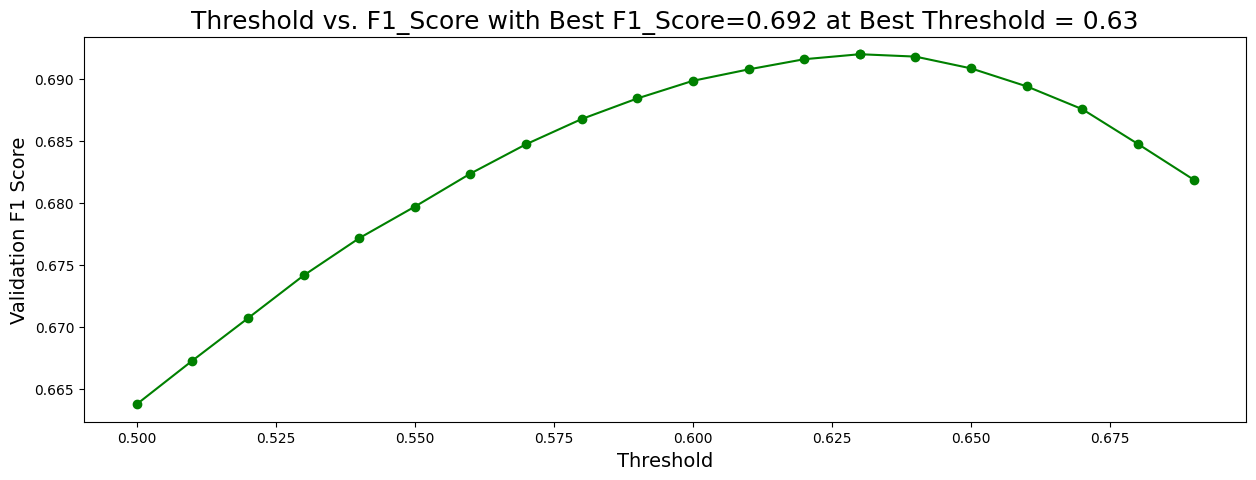

When using optimal threshold = 0.63...
Q0: F1 = 0.6639182886657179
Q1: F1 = 0.4984201215984612
Q2: F1 = 0.5086472177648145
Q3: F1 = 0.6642933173350303
Q4: F1 = 0.6210627362829575
Q5: F1 = 0.6364875825330623
Q6: F1 = 0.6156014776622509
Q7: F1 = 0.5553625346625846
Q8: F1 = 0.6247059148641292
Q9: F1 = 0.561951460327379
Q10: F1 = 0.6037430543772575
Q11: F1 = 0.5135185281264205
Q12: F1 = 0.45293750449390197
Q13: F1 = 0.6338406977961869
Q14: F1 = 0.5872636534616551
Q15: F1 = 0.48213288927143416
Q16: F1 = 0.5473609595150755
Q17: F1 = 0.49624725262660335
==> Overall F1 = 0.6920131195523167
s


In [44]:
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(15, 5))
plt.plot(thresholds, scores, '-o', color='green')
plt.scatter([best_threshold], [best_socre], color='green')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

# Submission Jo Wilder

In [45]:
import jo_wilder_310 as jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [46]:
models_list = [[CatBoostClassifier().load_model(
    f"fold{fold}_q{q}.cbm"
) for fold in range(2)] for q in range(1, 19)]

In [47]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    a,b = limits[grp]    
        
    df = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    df = feature_engineer(df, grp, use_extra=True, feature_suffix='')
    df = time_feature(df)
    
    fold = 1
    preds = []
    a,b = limits[grp]
    
    for q in range(a, b):
        print("Question: ",q)
        FEATURES = importance_dict[str(q)]
        model = models_list[q-1][fold]
        
        pred = model.predict_proba(df[FEATURES].astype(np.float32))[:,1]
        mask = sample_submission.question == q 
        sample_submission.loc[mask, 'correct'] = (pred > best_threshold).astype('int') 

    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18


In [48]:
sub = pd.read_csv('submission.csv')
print("Shape: ",sub.shape)
sub1 = sub[sub["session_id"].str.contains("session_id") == False]
print("Shape: ",sub1.shape)
sub1["correct"] = pd.to_numeric(sub1["correct"], downcast="float")
print("==> Test MEAN: ",np.mean(sub1["correct"]))
sub1.head(18)

Shape:  (54, 2)
Shape:  (54, 2)
==> Test MEAN:  0.6111111


,session_id,correct
0,20090109393214576_q1,1.0
1,20090109393214576_q2,1.0
2,20090109393214576_q3,1.0
3,20090109393214576_q4,1.0
4,20090109393214576_q5,0.0
5,20090109393214576_q6,1.0
6,20090109393214576_q7,1.0
7,20090109393214576_q8,0.0
8,20090109393214576_q9,1.0
9,20090109393214576_q10,0.0
